In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import subprocess
import os
from contextlib import contextmanager
import re
import pandas
import pathlib

In [2]:
# small utility to clean up backup files:
def clean():
    print(subprocess.run("rm -f \#*; rm -fr bck.*",shell=True))
# small utility to run with mpiexec
def run_mpi(cmd,nprocs=1):
    return subprocess.run("mpiexec -np {} --oversubscribe {}".format(nprocs,cmd),shell=True)
# change directory and execute commands
# at the end of the context (or in the event of an error),
# previous working directory is restored
@contextmanager
def cd(newdir: os.PathLike):
    prevdir = os.getcwd()
    path=os.path.expanduser(newdir)
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    try:
        os.chdir(path)
    except FileNotFoundError:
        try:
            os.mkdir(path)
            os.chdir(path)
        except:
            FileExistsError
    try:
        yield
    finally:
        os.chdir(prevdir)

In [3]:
# this is our standard input file:
!cat grompp.mdp

integrator               = md
dt                       = 0.002
nsteps                   = 500000

nstlog                   = 500
nstenergy                = 500
nstxout-compressed       = 500

continuation             = yes
constraints              = h-bonds
constraint-algorithm     = lincs

cutoff-scheme            = Verlet

coulombtype              = PME
rcoulomb                 = 1.0

vdwtype                  = Cut-off
rvdw                     = 1.0
DispCorr                 = EnerPres

tcoupl                   = V-rescale
tc-grps                  = Protein  SOL
tau-t                    = 0.1      0.1
ref-t                    = 300      300


Notice that we use two temperature groups (protein and solvent). However, when we will do solute tempering, both temperatures will be equal to 300K

## Exercise 1a: Test with different temperatures

We prepare inputs for a range of temperature and run them for 1 ns (500k steps)

In [4]:
Ts=[300, 400, 500, 600, 700, 800, 900, 1000]

In [4]:
# this box takes a while to run!
for T in Ts:
    with cd("1a/T"+str(T)):
        with open("../../grompp.mdp") as f:
            with open("grompp.mdp","w") as ff:
                for line in f:
                    line=line.strip() # remove newline
                    if re.match("^ *ref-t.*$",line):
                        line=re.sub("300",str(T),line)
                    print(line,file=ff)
        run_mpi("gmx_mpi grompp -c ../../conf.gro -p ../../topol.top")
        run_mpi("gmx_mpi mdrun -nsteps 500000 -pin on -ntomp 12")

               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 400 K
Calculated rlist for 1x1 atom pair-list as 1.046 nm, buffer size 0.046 nm
Set rlist, assuming 4x4 atom pair-list, to 1.004 nm, buffer size 0.004 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 500 K
Calculated rlist for 1x1 atom pair-list as 1.056 nm, buffer size 0.056 nm
Set rlist, assuming 4x4 atom pair-list, to 1.010 nm, buffer size 0.010 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 600 K
Calculated rlist for 1x1 atom pair-list as 1.064 nm, buffer size 0.064 nm
Set rlist, assuming 4x4 atom pair-list, to 1.016 nm, buffer size 0.016 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 700 K
Calculated rlist for 1x1 atom pair-list as 1.073 nm, buffer size 0.073 nm
Set rlist, assuming 4x4 atom pair-list, to 1.021 nm, buffer size 0.021 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 800 K
Calculated rlist for 1x1 atom pair-list as 1.081 nm, buffer size 0.081 nm
Set rlist, assuming 4x4 atom pair-list, to 1.026 nm, buffer size 0.026 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 900 K
Calculated rlist for 1x1 atom pair-list as 1.088 nm, buffer size 0.088 nm
Set rlist, assuming 4x4 atom pair-list, to 1.031 nm, buffer size 0.031 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 1000 K
Calculated rlist for 1x1 atom pair-list as 1.095 nm, buffer size 0.095 nm
Set rlist, assuming 4x4 atom pair-list, to 1.036 nm, buffer size 0.036 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

We then generate COLVAR files (with phi,psi time series) and read them in pandas dataframes:

In [5]:
colvar=[]

for T in Ts:
    with cd("1a/T"+str(T)):
        with open("plumed.dat","w") as f:
                  print("""
MOLINFO STRUCTURE=../../ala.pdb 
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
PRINT ARG=phi,psi FILE=COLVAR 
                  """, file=f)
        subprocess.run("plumed driver --ixtc traj_comp.xtc --plumed plumed.dat",shell=True)
        colvar.append(plumed.read_as_pandas("COLVAR"))

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


We then plot the resulting time series for phi

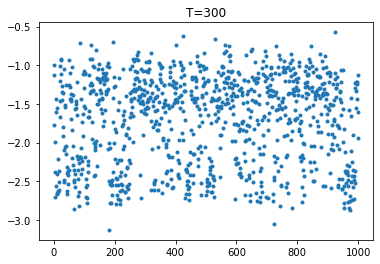

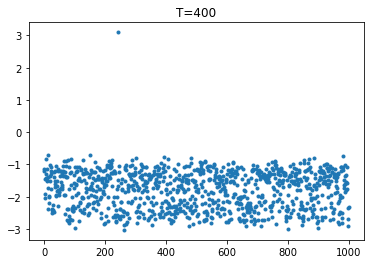

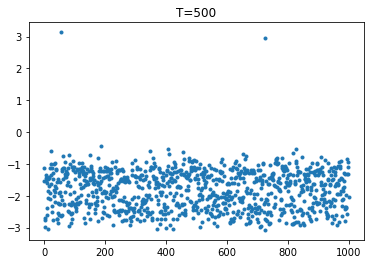

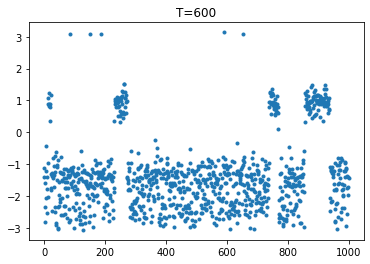

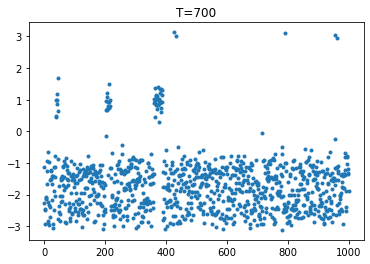

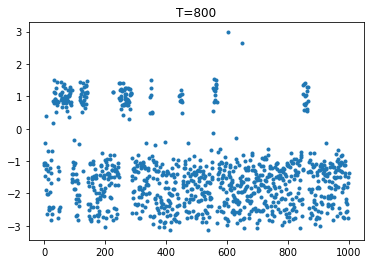

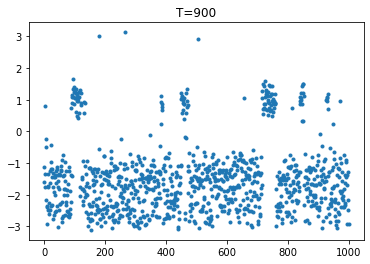

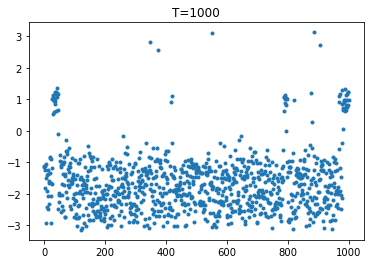

In [6]:
for i in range(len(Ts)):
    plt.title("T={}".format(Ts[i]))
    plt.plot(colvar[i].time,colvar[i].phi,".")
    plt.show()

As you can see, the number of transitions to the higher energy state is increasing with temperature. Notice that we have two simultaneous effects:
- The population of state B is increasing as we increase the temperature
- Also the rates (both A->B and B->A are increasign when we increase the temperature

## Exercise 1b: Run a parallel tempering simulation

Based on the analysis above, we decide to use T=800 at maximum temperature. This decision is partly arbitrary, but at least we should be able to get an approximate value with an analysis similar to what we have done above. Also notice that parallel tempering (and also solute tempering) simulations are not optimal for systems with such a high barrier on a single degree of freedom. In cases where we, for instance, combine parallel tempering (or solute tempering) with metadynamics or other enhanced sampling methods, determining the optimal temperature for the hottest replica should be might be more difficult.

In [7]:
Tmax=800
Ts=np.geomspace(300,Tmax,32)

We now run a parallel tempering simulations with a range of temperatures

In [ ]:
# this box takes a while to run!
with cd("1b/32reps"):
    for i in range(len(Ts)):
        with cd("replica{}".format(i)):
            with open("../../../grompp.mdp") as f:
                with open("grompp.mdp","w") as ff:
                    for line in f:
                        line=line.strip() # remove newline
                        if re.match("^ *ref-t.*$",line):
                            line=re.sub("300",str(Ts[i]),line)
                        print(line,file=ff)
            run_mpi("gmx_mpi grompp -c ../../../conf.gro -p ../../../topol.top")
    run_mpi("gmx_mpi mdrun -multidir replica? replica?? -replex 100 -nsteps 500000 -ntomp 1",len(Ts))

               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 320.272 K
Calculated rlist for 1x1 atom pair-list as 1.038 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 341.914 K
Calculated rlist for 1x1 atom pair-list as 1.040 nm, buffer size 0.040 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 365.019 K
Calculated rlist for 1x1 atom pair-list as 1.042 nm, buffer size 0.042 nm
Set rlist, assuming 4x4 atom pair-list, to 1.002 nm, buffer size 0.002 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 389.684 K
Calculated rlist for 1x1 atom pair-list as 1.045 nm, buffer size 0.045 nm
Set rlist, assuming 4x4 atom pair-list, to 1.003 nm, buffer size 0.003 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 416.017 K
Calculated rlist for 1x1 atom pair-list as 1.048 nm, buffer size 0.048 nm
Set rlist, assuming 4x4 atom pair-list, to 1.005 nm, buffer size 0.005 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 444.129 K
Calculated rlist for 1x1 atom pair-list as 1.050 nm, buffer size 0.050 nm
Set rlist, assuming 4x4 atom pair-list, to 1.007 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 474.14 K
Calculated rlist for 1x1 atom pair-list as 1.053 nm, buffer size 0.053 nm
Set rlist, assuming 4x4 atom pair-list, to 1.008 nm, buffer size 0.008 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 506.18 K
Calculated rlist for 1x1 atom pair-list as 1.056 nm, buffer size 0.056 nm
Set rlist, assuming 4x4 atom pair-list, to 1.010 nm, buffer size 0.010 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 540.384 K
Calculated rlist for 1x1 atom pair-list as 1.059 nm, buffer size 0.059 nm
Set rlist, assuming 4x4 atom pair-list, to 1.012 nm, buffer size 0.012 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 576.9 K
Calculated rlist for 1x1 atom pair-list as 1.062 nm, buffer size 0.062 nm
Set rlist, assuming 4x4 atom pair-list, to 1.014 nm, buffer size 0.014 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 615.883 K
Calculated rlist for 1x1 atom pair-list as 1.066 nm, buffer size 0.066 nm
Set rlist, assuming 4x4 atom pair-list, to 1.017 nm, buffer size 0.017 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 657.501 K
Calculated rlist for 1x1 atom pair-list as 1.069 nm, buffer size 0.069 nm
Set rlist, assuming 4x4 atom pair-list, to 1.019 nm, buffer size 0.019 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 701.931 K
Calculated rlist for 1x1 atom pair-list as 1.073 nm, buffer size 0.073 nm
Set rlist, assuming 4x4 atom pair-list, to 1.021 nm, buffer size 0.021 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 749.363 K
Calculated rlist for 1x1 atom pair-list as 1.077 nm, buffer size 0.077 nm
Set rlist, assuming 4x4 atom pair-list, to 1.024 nm, buffer size 0.024 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 800 K
Calculated rlist for 1x1 atom pair-list as 1.081 nm, buffer size 0.081 nm
Set rlist, assuming 4x4 atom pair-list, to 1.026 nm, buffer size 0.026 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipeptide in vacuum in water'
500000 steps,   1000.0 ps.
starting mdrun 'alanine dipe

In [8]:
! grep -A 4 average probabilities 1b/32reps/replica0/md.log

grep: probabilities: No such file or directory
1b/32reps/replica0/md.log:Repl  average probabilities:
1b/32reps/replica0/md.log-Repl     0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31
1b/32reps/replica0/md.log-Repl      .25  .24  .24  .26  .27  .27  .27  .30  .29  .31  .31  .31  .33  .34  .36  .34  .36  .37  .38  .36  .39  .38  .40  .43  .44  .42  .44  .44  .45  .46  .45
1b/32reps/replica0/md.log-Repl  number of exchanges:
1b/32reps/replica0/md.log-Repl     0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31
--
1b/32reps/replica0/md.log:Repl  average number of exchanges:
1b/32reps/replica0/md.log-Repl     0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31
1b/32reps/repli

Acceptances are very reasonable. They are not exactly uniform (22% - 45%), and slighly below the requested value (30%). You could try e.g. with 48 replicas to see if you can arrive to 30%. Or you could try to redistribute replicas better (more replicas at low temperature and less at high temperature) to make acceptance more homogenous.

In [9]:
colvar=[]

for i in range(len(Ts)):
    with cd("1b/32reps/replica"+str(i)):
        with open("plumed.dat","w") as f:
            print("""
MOLINFO STRUCTURE=../../../ala.pdb 
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
PRINT ARG=phi,psi FILE=COLVAR 
                  """,file=f)
        subprocess.run("plumed driver --ixtc traj_comp.xtc --plumed plumed.dat",shell=True)
            
        colvar.append(plumed.read_as_pandas("COLVAR"))

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     0.090466     0.090466     0.090466     0.090466
PLUMED: 1 Prepare dependencies                          1001     0.001991     0.000002     0.000001     0.000011
PLUMED: 2 Sharing data                                  1001     0.010066     0.000010     0.000009     0.000255
PLUMED: 3 Waiting for data                              1001     0.003405     0.000003     0.000003     0.000021
PLUMED: 4 Calculating (forward loop)                    1001     0.011021     0.000011     0.000010     0.000042
PLUMED: 5 Applying (backward loop)                      1001     0.014642     0.000015     0.000014     0.000033
PLUMED: 6 Update                                        1001     0.009120     0.000009     0.000008     0.000056


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     0.090765     0.090765     0.090765     0.090765
PLUMED: 1 Prepare dependencies                          1001     0.002006     0.000002     0.000001     0.000013
PLUMED: 2 Sharing data                                  1001     0.009933     0.000010     0.000009     0.000251
PLUMED: 3 Waiting for data                              1001     0.003396     0.000003     0.000003     0.000020
PLUMED: 4 Calculating (forward loop)                    1001     0.011115     0.000011     0.000010     0.000047
PLUMED: 5 Applying (backward loop)                      1001     0.014670     0.000015     0.000014     0.000026
PLUMED: 6 Update                                        1001     0.009200     0.000009     0.000008     0.000055


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     0.091801     0.091801     0.091801     0.091801
PLUMED: 1 Prepare dependencies                          1001     0.002049     0.000002     0.000001     0.000011
PLUMED: 2 Sharing data                                  1001     0.010117     0.000010     0.000009     0.000266
PLUMED: 3 Waiting for data                              1001     0.003427     0.000003     0.000003     0.000020
PLUMED: 4 Calculating (forward loop)                    1001     0.011202     0.000011     0.000010     0.000043
PLUMED: 5 Applying (backward loop)                      1001     0.014843     0.000015     0.000014     0.000028
PLUMED: 6 Update                                        1001     0.009571     0.000010     0.000009     0.000058


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


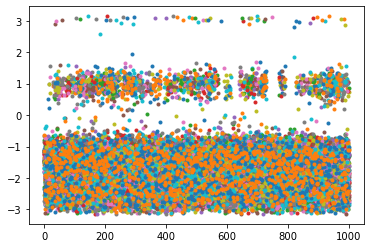

In [10]:
for i in range(len(Ts)):
    plt.plot(colvar[i].time,colvar[i].phi,".")

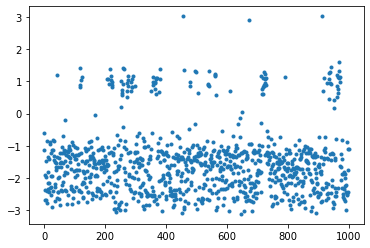

In [11]:
plt.plot(colvar[i].time,colvar[31].phi,".")

In [12]:
pop_pt=[]
for i in range(len(Ts)):
    pop_pt.append(
        np.sum(np.logical_and(colvar[i].phi<2.0,colvar[i].phi>0))/
        np.sum(np.logical_or(colvar[i].phi>2.0,colvar[i].phi<0))
    )

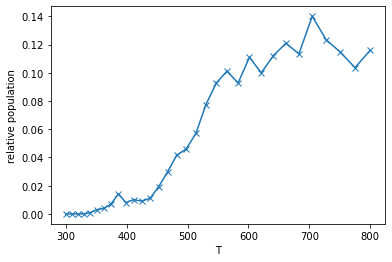

In [13]:
plt.plot(Ts,pop_pt,"x-")
plt.xlabel("T")
plt.ylabel("relative population")
plt.show()

## Exercise 2a: Setting up scaled Hamiltonians
We now learn how to use the `plumed partial_tempering` tool to prepared scaled Hamiltonians. Notice that you could do the same using some other tool or editing by hand the top file.

The first thing that we have to do is to construct a self-contained top file

In [14]:
with cd("2a"):
    run_mpi("gmx_mpi grompp -p ../topol.top -f ../grompp.mdp -c ../conf.gro -pp processed.top")

               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K


Number of degrees of freedom in T-Coupling group Protein is 53.95
Number of degrees of freedom in T-Coupling group SOL is 3135.05
Estimate for the relative computational load of the PME mesh part: 0.19

Back Off! I just backed up topol.tpr to ./#topol.tpr.1#

GROMACS reminds you: "This Puke Stinks Like Beer" (LIVE)



Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


Then we can edit it. Usually this can be done with a text editor. However, if you want to batch process many systems, or do it in a notebook as here, you can use the following script:

In [15]:
with cd("2a/"):
    with open("processed.top") as f:
        with open("processed_selected.top","w") as ff:
            in_molecules=False
            in_atoms=False
            ala_done=False
            for l in f:
                if(in_atoms) and not re.match(" *;.*",l) and not re.match(r"\[.*",l) and len(l.split())>2:
                    ll=l.split()
                    ll[1]=ll[1]+"_"
                    ll=" ".join(ll)
                    print(ll,file=ff)
                else:
                    print(l,end="",file=ff)
                if not ala_done and re.match(r"\[ *moleculetype *\]",l):
                    in_molecules=True
                    ala_done=True # track when alanine has been done so that we only modify that
                elif in_molecules and re.match(r"\[ *atoms *\]",l):
                    in_atoms=True
                elif re.match(r"\[.*",l):
                    in_molecules=False
                    in_atoms=False
    # then we generate two scaled topologies with factors 1.0 and 0.5
    run_mpi("plumed partial_tempering 1.0 < processed_selected.top > scaled1.0.top")
    run_mpi("plumed partial_tempering 0.5 < processed_selected.top > scaled0.5.top")

We can see the differences between the two scaled topologies:
- New atom types have been added (e.g., `C_`)
- Charges have been modified
- All torsions have been put "inline". No generic `HC CT C O` torsions, but specific `1 2 5 6` torsions. This allows to scale only portions of a molecule.

In [16]:
!diff 2a/scaled1.0.top 2a/scaled0.5.top

40c40
< Br_ Br 79.90 0.0000 A 0.395559 1.33888  ; scaled
---
> Br_ Br 79.90 0.0000 A 0.395559 0.66944  ; scaled
42c42
< C_ C 12.01 0.0000 A 0.339967 0.359824  ; scaled
---
> C_ C 12.01 0.0000 A 0.339967 0.179912  ; scaled
44c44
< CA_ CA 12.01 0.0000 A 0.339967 0.359824  ; scaled
---
> CA_ CA 12.01 0.0000 A 0.339967 0.179912  ; scaled
46c46
< CB_ CB 12.01 0.0000 A 0.339967 0.359824  ; scaled
---
> CB_ CB 12.01 0.0000 A 0.339967 0.179912  ; scaled
48c48
< CC_ CC 12.01 0.0000 A 0.339967 0.359824  ; scaled
---
> CC_ CC 12.01 0.0000 A 0.339967 0.179912  ; scaled
50c50
< CK_ CK 12.01 0.0000 A 0.339967 0.359824  ; scaled
---
> CK_ CK 12.01 0.0000 A 0.339967 0.179912  ; scaled
52c52
< CM_ CM 12.01 0.0000 A 0.339967 0.359824  ; scaled
---
> CM_ CM 12.01 0.0000 A 0.339967 0.179912  ; scaled
54c54
< CN_ CN 12.01 0.0000 A 0.339967 0.359824  ; scaled
---
> CN_ CN 12.01 0.0000 A 0.339967 0.179912  ; scaled
56c56
< CQ_ CQ 12.01 0.0000 A 0.339967 0.359824  ; scaled
---
> CQ_ CQ 12.01 0.0000 A 0.339967

## Exercise 2b: Sanity check on generated topologies

We now do some sanity check on the resulting topologies. This is mostly to make sure that the `plumed partial_tempering` script edited them correctly.

To this aim we generate a short reference trajectory first (it's not important which force field we use at this step).

In [17]:
with cd("2b"):
    run_mpi("gmx_mpi grompp -f ../grompp.mdp -c ../conf.gro -p ../topol.top")
    run_mpi("gmx_mpi mdrun -nsteps 5000")
    

               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...


Number of degrees of freedom in T-Coupling group Protein is 53.95
Number of degrees of freedom in T-Coupling group SOL is 3135.05
Estimate for the relative computational load of the PME mesh part: 0.19


Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data



Back Off! I just backed up topol.tpr to ./#topol.tpr.1#

GROMACS reminds you: "It all works because Avogadro's number is closer to infinity than to 10." (Ralph Baierlein)

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sij

We then "rerun" its energy with different topologies. Specifically, we use the original tpr file and a new one obtained from topol_scaled1.0.top, which has been obtained with scaling factor 1.0. The two calculations should return identical energies

In [18]:
with cd("2b"):
    run_mpi("cp ../2a/processed_selected.top processed_selected.top")
    run_mpi("plumed partial_tempering 1.0 < processed_selected.top > topol_scaled1.0.top")
    run_mpi("gmx_mpi grompp -f ../grompp.mdp -c ../conf.gro -p topol_scaled1.0.top -o topol_scaled1.0.tpr")
    with cd("rerun0"):
        run_mpi("gmx_mpi mdrun -rerun ../traj_comp.xtc -s ../topol.tpr")
        run_mpi("echo 1 2 3 4 5 6 7 8 9 10 11 | gmx_mpi energy -xvg no")
    with cd("rerun1"):
        run_mpi("gmx_mpi mdrun -rerun ../traj_comp.xtc -s ../topol_scaled1.0.tpr")
        run_mpi("echo 1 2 3 4 5 6 7 8 9 10 11 | gmx_mpi energy -xvg no")

               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K


Number of degrees of freedom in T-Coupling group Protein is 53.95
Number of degrees of freedom in T-Coupling group SOL is 3135.05


Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


Estimate for the relative computational load of the PME mesh part: 0.19

Back Off! I just backed up topol_scaled1.0.tpr to ./#topol_scaled1.0.tpr.1#

GROMACS reminds you: "There are only two hard things in computer science - cache invalidation, naming things and off-by-one errors." (Anonymous)

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Tee


Statistics over 5001 steps [ 0.0000 through 10.0000 ps ], 11 data sets
All statistics are over 11 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Bond                        12.8501       0.93    5.54295    1.76035  (kJ/mol)
Angle                       31.4149        3.3    9.29962   -14.1766  (kJ/mol)
Proper Dih.                 45.7409        1.7    4.41161   -2.62365  (kJ/mol)
Improper Dih.               2.41675       0.48    1.38529  -0.191024  (kJ/mol)
LJ-14                       13.6088        1.6    4.45048    3.70408  (kJ/mol)
Coulomb-14                  195.498        2.7     6.9361   -11.1147  (kJ/mol)
LJ (SR)                     3321.67         54    169.128    -173.23  (kJ/mol)
Disper. corr.              -188.172          0          0          0  (kJ/mol)
Coulomb (SR)               -24668.2         78    291.718    198.491  (kJ/mol)
Coul. recip.            

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Statistics over 5001 steps [ 0.0000 through 10.0000 ps ], 11 data sets
All statistics are over 11 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Bond                        12.8501       0.93    5.54295    1.76035  (kJ/mol)
Angle                       31.4149        3.3    9.29962   -14.1766  (kJ/mol)
Proper Dih.                 45.7409        1.7    4.41161   -2.62365  (kJ/mol)
Improper Dih.               2.41675       0.48    1.38529  -0.191024  (kJ/mol)
LJ-14                       13.6088        1.6    4.45048    3.70408  (kJ/mol)
Coulomb-14                  195.498        2.7     6.9361   -11.1147  (kJ/mol)
LJ (SR)                     3321.67         54    169.128    -173.23  (kJ/mol)
Disper. corr.              -188.172          0          0          0  (kJ/mol)
Coulomb (SR)               -24668.2         78    291.718    198.491  (kJ/mol)
Coul. recip.            

               :-) GROMACS - gmx energy, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

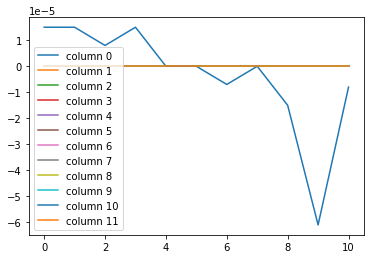

In [19]:
ene=pandas.read_csv("2b/rerun0/energy.xvg",header=None,delim_whitespace=True)
ene_scaled=pandas.read_csv("2b/rerun1/energy.xvg",header=None,delim_whitespace=True)
difference=np.array(ene)-np.array(ene_scaled)
for i in range(difference.shape[1]):
    plt.plot(difference[:,i],label="column {}".format(i))
plt.legend()
plt.show()

Only column 10 (long range Ewald) has some minor difference (1e-5), due to some (unknown?) numerical reason. This is not going to be a problem, since this error is several orders of magnitude lower than kBT

Next we generate a top file where all atoms were selected for scaling. From the statistical mechanics point of view, this is identical to increasing the temperature (indeed, you can show that by properly modifying the time step you should obtain identical trajectories). Here it is interesting because we can check if the energy terms do what we expect.

In [22]:
with cd("2b/"):
    with open("../2a/processed.top") as f:
        with open("processed_selected_whole.top","w") as ff:
            in_molecules=False
            in_atoms=False
            ala_done=False
            for l in f:
                ala_done=False # also modify water
                if(in_atoms) and not re.match(" *;.*",l) and not re.match(r"\[.*",l) and len(l.split())>2:
                    ll=l.split()
                    ll[1]=ll[1]+"_"
                    ll=" ".join(ll)
                    print(ll,file=ff)
                else:
                    print(l,end="",file=ff)
                if not ala_done and re.match(r"\[ *moleculetype *\]",l):
                    in_molecules=True
                    ala_done=True
                elif in_molecules and re.match(r"\[ *atoms *\]",l):
                    in_atoms=True
                elif re.match(r"\[.*",l):
                    in_molecules=False
                    in_atoms=False
    run_mpi("plumed partial_tempering 0.1 < processed_selected_whole.top > topol_scaled_whole0.1.top")
    run_mpi("gmx_mpi grompp -f ../grompp.mdp -c ../conf.gro -p topol_scaled_whole0.1.top -o topol_scaled_whole0.1.tpr")
    with cd("rerun_whole"):
        run_mpi("gmx_mpi mdrun -rerun ../traj_comp.xtc -s ../topol_scaled_whole0.1.tpr")
        run_mpi("echo 1 2 3 4 5 6 7 8 9 10 11 | gmx_mpi energy -xvg no")

               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K


Number of degrees of freedom in T-Coupling group Protein is 53.95
Number of degrees of freedom in T-Coupling group SOL is 3135.05
Estimate for the relative computational load of the PME mesh part: 0.19

Back Off! I just backed up topol_scaled_whole0.1.tpr to ./#topol_scaled_whole0.1.tpr.1#


Calculated rlist for 1x1 atom pair-list as 1.000 nm, buffer size 0.000 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data



GROMACS reminds you: "... an excellent man, almost worthy of such a wife ..." (Jane Eyre in Jane Eyre by Charlotte Bronte)

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Te


Statistics over 5001 steps [ 0.0000 through 10.0000 ps ], 11 data sets
All statistics are over 11 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Bond                        12.8501       0.93    5.54295    1.76035  (kJ/mol)
Angle                       31.4149        3.3    9.29962   -14.1766  (kJ/mol)
Proper Dih.                 4.57409       0.17   0.441161  -0.262365  (kJ/mol)
Improper Dih.              0.241675      0.048   0.138529 -0.0191024  (kJ/mol)
LJ-14                       1.36088       0.16   0.445048   0.370408  (kJ/mol)
Coulomb-14                  19.5498       0.27   0.693611   -1.11147  (kJ/mol)
LJ (SR)                     332.167        5.4    16.9128   -17.3229  (kJ/mol)
Disper. corr.              -18.8172          0          0          0  (kJ/mol)
Coulomb (SR)               -2466.83        7.8    29.1721    19.8498  (kJ/mol)
Coul. recip.            

               :-) GROMACS - gmx energy, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

In [23]:
ene_whole_scaled=pandas.read_csv("2b/rerun_whole/energy.xvg",header=None,delim_whitespace=True)

In [24]:
for i in range(1,12):
    print(ene[i]/ene_whole_scaled[i])

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
Name: 1, dtype: float64
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
Name: 2, dtype: float64
0     10.000000
1     10.000000
2     10.000000
3      9.999999
4     10.000001
5      9.999998
6      9.999999
7     10.000001
8     10.000001
9     10.000001
10    10.000000
Name: 3, dtype: float64
0     10.000004
1     10.000042
2     10.000014
3     10.000012
4      9.999997
5      9.999916
6     10.000000
7     10.000008
8      9.999977
9      9.999989
10     9.999997
Name: 4, dtype: float64
0      9.999994
1      9.999998
2     10.000001
3     10.000004
4     10.000002
5      9.999996
6     10.000000
7      9.999999
8      9.999999
9     10.000001
10    10.000000
Name: 5, dtype: float64
0     10.000010
1     10.000011
2     10.000012
3     10.000014
4     10.000009
5     10.000010
6     10.000008
7     10.000012
8   

All energy terms have been scaled down by a factor 10, with the exception of bonds and bends that were not touched.

Notice that last column is total potential energy, so it contains both unscaled and scaled terms.

## Exercise 2c: Sanity check on replica-exchange implementation

Once we know the topologies are fine, we should double check if the gromacs+plumed implementation is correctly calculating the acceptance.

We run a replica exchange simulation with 2 replicas with identical Hamiltonians. Acceptance shoud be 1.

In [25]:
with cd("2c/"):
    with open("plumed.dat","w") as f:
        print("",file=f) # empty
    run_mpi("cp ../2b/topol_scaled1.0.top .")
    with cd ("rep0"):
        run_mpi("gmx_mpi grompp -c ../../conf.gro -f ../../grompp.mdp -p ../../topol.top")
    with cd ("rep1"):
        run_mpi("gmx_mpi grompp -c ../../conf.gro -f ../../grompp.mdp -p ../topol_scaled1.0.top")
    run_mpi("gmx_mpi mdrun -nsteps 1000 -multidir rep? -replex 200 -hrex -plumed ../plumed.dat",2)    

               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K


Number of degrees of freedom in T-Coupling group Protein is 53.95
Number of degrees of freedom in T-Coupling group SOL is 3135.05


Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


Estimate for the relative computational load of the PME mesh part: 0.19

Back Off! I just backed up topol.tpr to ./#topol.tpr.1#

GROMACS reminds you: "I have had my results for a long time, but I do not yet know how I am to arrive at them." (Carl Friedrich Gauss)

               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall 

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K


Number of degrees of freedom in T-Coupling group Protein is 53.95
Number of degrees of freedom in T-Coupling group SOL is 3135.05
Estimate for the relative computational load of the PME mesh part: 0.19

Back Off! I just backed up topol.tpr to ./#topol.tpr.1#


Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data



GROMACS reminds you: "Those people who think they know everything are a great annoyance to those of us who do." (Isaac Asimov)

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent    

In [26]:
!grep Repl 2c/rep0/md.log

Initializing Replica Exchange
Repl  There are 2 replicas:
Replica-exchange molecular dynamics method for protein folding
Replica exchange in temperature
Replica exchange interval: 200
Replica random seed: -4301313
Replica exchange information below: ex and x = exchange, pr = probability
Replica exchange at step 200 time 0.40000
Repl 0 <-> 1  dE_term = -0.000e+00 (kT)
Repl ex  0 x  1
Repl pr   1.0
Replica exchange at step 400 time 0.80000
Repl ex  0    1
Repl pr      
Replica exchange at step 600 time 1.20000
Repl 0 <-> 1  dE_term = -0.000e+00 (kT)
Repl ex  0 x  1
Repl pr   1.0
Replica exchange at step 800 time 1.60000
Repl ex  0    1
Repl pr      
Replica exchange statistics
Repl  4 attempts, 2 odd, 2 even
Repl  average probabilities:
Repl     0    1
Repl      1.0
Repl  number of exchanges:
Repl     0    1
Repl        2
Repl  average number of exchanges:
Repl     0    1
Repl      1.0
Repl        Empirical Transition Matrix
Repl       1       2
Repl  0.5000  0.5000  0
Repl  0.5000  0.50

In [27]:
! grep "^dplumed" 2c/rep0/md.log

dplumed =  0.000e+00  dE_Term =  0.000e+00 (kT)
dplumed =  0.000e+00  dE_Term =  0.000e+00 (kT)


## Exercise 2d: Find minimum scaling factor needed to cross the barrier

In [29]:
lambdas=[1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

In [27]:
#this box takes a while to run
for l in lambdas:
    with cd("2d/l"+str(l)):
        run_mpi("cp ../../2a/processed_selected.top processed_selected.top")
        run_mpi("plumed partial_tempering {} < processed_selected.top > topol.top".format(l))
        run_mpi("gmx_mpi grompp -c ../../conf.gro -f ../../grompp.mdp")
        run_mpi("gmx_mpi mdrun -nsteps 500000 -pin on -ntomp 12")

               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.035 nm, buffer size 0.035 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.035 nm, buffer size 0.035 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

In [30]:
colvar=[]

for l in lambdas:
    with cd("2d/l"+str(l)):
        with open("plumed.dat","w") as f:
                  print("""
MOLINFO STRUCTURE=../../ala.pdb 
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
PRINT ARG=phi,psi FILE=COLVAR 
                  """, file=f)
        subprocess.run("plumed driver --ixtc traj_comp.xtc --plumed plumed.dat",shell=True)
        colvar.append(plumed.read_as_pandas("COLVAR"))

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary conditio

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


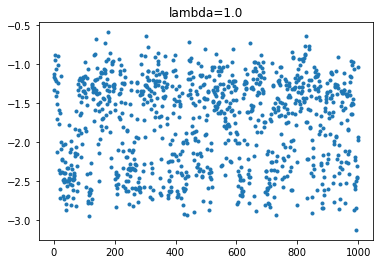

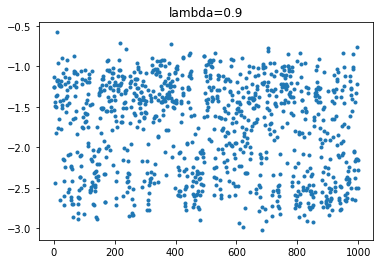

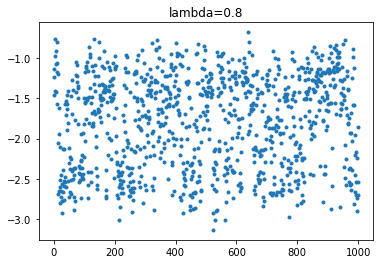

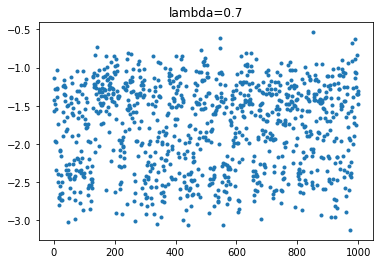

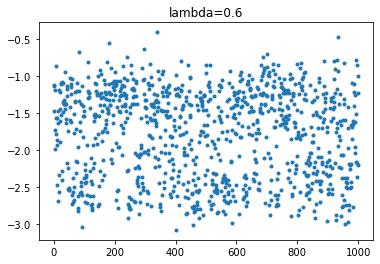

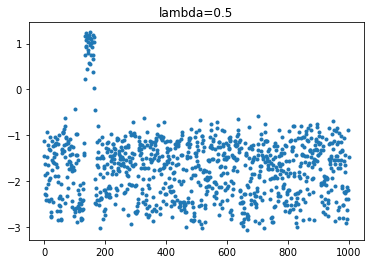

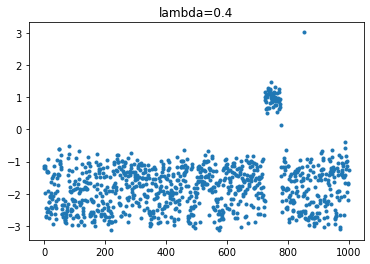

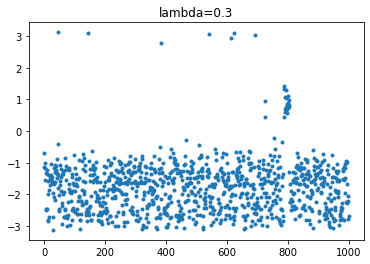

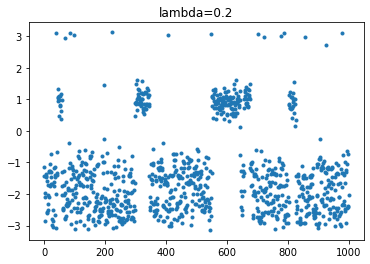

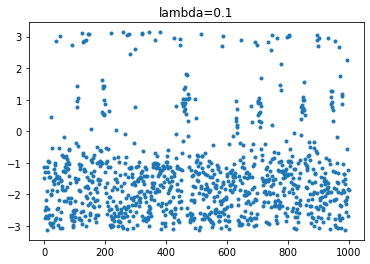

In [31]:
for i in range(len(lambdas)):
    plt.title("lambda={}".format(lambdas[i]))
    plt.plot(colvar[i].time,colvar[i].phi,".")
    plt.show()

Looks like 0.15 might be a reasonable value. Notice that it is not too dissimilar from 300/800=0.375

In any case, we expect the need to go to a lower scaling value in this case because solvent is not scaled at all. I will proceed with 0.15 as a reasonable choice

In [32]:
300/800

0.375

## Exercise 3: Run Hamiltonian replica exchange simulations

Now that we chose the minumum lambda we can setup a tentative hrex simulation. I am trying first a linearly spacing lambda. By experience, linear spacing works better for lambda than logarithmic spacing (though this could be very system dependent!). In any case, we will see later how to optimize the lambda ladder if needed.

In [34]:
lambda_min=0.15
lambdas=np.linspace(1.0,lambda_min,6)

In [32]:
#this box takes a while to run
with cd("3/6reps"):
    with open("plumed.dat","w") as f:
        print("",file=f) # empty
    for i in range(len(lambdas)):
        with cd("replica{}".format(i)):
            run_mpi("cp ../../../2a/processed_selected.top processed_selected.top")
            run_mpi("plumed partial_tempering {} < processed_selected.top > topol.top".format(lambdas[i]))
            run_mpi("gmx_mpi grompp -c ../../../conf.gro -f ../../../grompp.mdp")
    run_mpi("gmx_mpi mdrun -multidir replica? -replex 200 -nsteps 500000 -ntomp 4 -hrex -plumed ../plumed.dat",len(lambdas))

               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.035 nm, buffer size 0.035 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

In [35]:
! grep -A 4 average probabilities 3/6reps/replica0/md.log

grep: probabilities: No such file or directory
3/6reps/replica0/md.log:Repl  average probabilities:
3/6reps/replica0/md.log-Repl     0    1    2    3    4    5
3/6reps/replica0/md.log-Repl      .55  .47  .41  .30  .12
3/6reps/replica0/md.log-Repl  number of exchanges:
3/6reps/replica0/md.log-Repl     0    1    2    3    4    5
--
3/6reps/replica0/md.log:Repl  average number of exchanges:
3/6reps/replica0/md.log-Repl     0    1    2    3    4    5
3/6reps/replica0/md.log-Repl      .57  .46  .42  .30  .12
3/6reps/replica0/md.log-
3/6reps/replica0/md.log-


Accepntace is fine, except for in the last pair of replicas. We will fix this later.

We then read the resulting trajectories.

In [36]:
colvar=[]

for i in range(len(lambdas)):
    with cd("3/6reps/replica"+str(i)):
        with open("plumed.dat","w") as f:
            print("""
MOLINFO STRUCTURE=../../../ala.pdb 
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
PRINT ARG=phi,psi FILE=COLVAR 
                  """,file=f)
        subprocess.run("plumed driver --ixtc traj_comp.xtc --plumed plumed.dat",shell=True)
            
        colvar.append(plumed.read_as_pandas("COLVAR"))

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary condi

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     0.092980     0.092980     0.092980     0.092980
PLUMED: 1 Prepare dependencies                          1001     0.002059     0.000002     0.000002     0.000013
PLUMED: 2 Sharing data                                  1001     0.010187     0.000010     0.000009     0.000251
PLUMED: 3 Waiting for data                              1001     0.003470     0.000003     0.000003     0.000020
PLUMED: 4 Calculating (forward loop)                    1001     0.011443     0.000011     0.000011     0.000044
PLUMED: 5 Applying (backward loop)                      1001     0.015032     0.000015     0.000014     0.000079
PLUMED: 6 Update                                        1001     0.009593     0.000010     0.000008     0.000054
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     0.091703     0.091703     0.091703     0.091703
PLUMED: 1 Prepare dependencies                          1001     0.002012     0.000002     0.000001     0.000012
PLUMED: 2 Sharing data                                  1001     0.010086     0.000010     0.000009     0.000261
PLUMED: 3 Waiting for data                              1001     0.003393     0.000003     0.000003     0.000021
PLUMED: 4 Calculating (forward loop)                    1001     0.011303     0.000011     0.000011     0.000042
PLUMED: 5 Applying (backward loop)                      1001     0.014596     0.000015     0.000014     0.000030
PLUMED: 6 Update                                        1001     0.009471     0.000009     0.000008     0.000059


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


It looks like there are transitions between the two minima (though probably not so many independent ones):

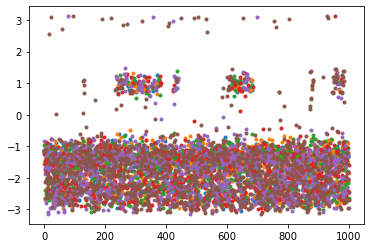

In [37]:
for i in range(len(lambdas)):
    plt.plot(colvar[i].time,colvar[i].phi,".")

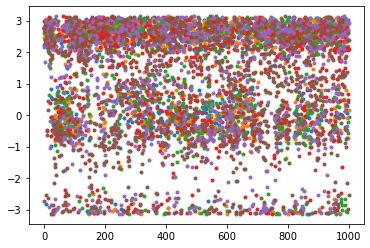

In [38]:
for i in range(len(lambdas)):
    plt.plot(colvar[i].time,colvar[i].psi,".")

We then compute the lambda dependent temperature and show it as if it was a "temperature dependence"

In [39]:
pop_hrex=[]
for i in range(len(lambdas)):
    pop_hrex.append(
        np.sum(np.logical_and(colvar[i].phi<2.0,colvar[i].phi>0))/
        np.sum(np.logical_or(colvar[i].phi>2.0,colvar[i].phi<0))
    )

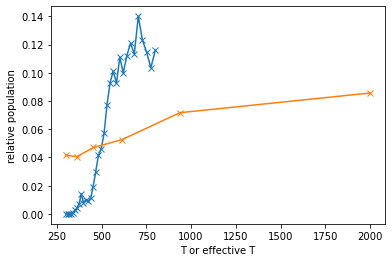

In [40]:
plt.plot(Ts,pop_pt,"x-",label="pt")
plt.plot(Ts[0]/lambdas,pop_hrex,"x-",label="hrex")
plt.xlabel("T or effective T")
plt.ylabel("relative population")
plt.show()

Clearly populations are noisy. You might rerun these simulations longer to have better estimates. In any case, there is clearly some correlation between the results.

## Exercise 4: Analyze Hamiltonian replica exchange simulations with WHAM

We are now ready to use a full binless WHAM analysis to recover the maximum amount of statistics from our hrex simulation.

In [39]:
# this box takes a while to run
with cd("3/6reps/"):
    run_mpi("gmx_mpi trjcat -cat -f replica?/traj_comp.xtc -o traj.xtc")
    for i in range(len(lambdas)):
        run_mpi("gmx_mpi mdrun -rerun traj.xtc -s replica{}/topol.tpr -e energy{}.edr".format(i,i))
        subprocess.run("echo 11 | gmx_mpi energy -f energy{}.edr -xvg no -o energy{}.xvg".format(i,i),shell=True)


               :-) GROMACS - gmx trjcat, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

Note that major changes are planned in future for trjcat, to improve usability and utility.
lasttime 0


Last frame       1000 time 1000.000   
Reading frame       0 time    0.000   
Continue writing frames from replica1/traj_comp.xtc t=0 ps, frame=1001      



lasttime 1000


Last frame       1000 time 1000.000   
Reading frame       0 time    0.000   
Continue writing frames from replica2/traj_comp.xtc t=0 ps, frame=2002      



lasttime 1000


Last frame       1000 time 1000.000   
Reading frame       0 time    0.000   
Continue writing frames from replica3/traj_comp.xtc t=0 ps, frame=3003      



lasttime 1000


Last frame       1000 time 1000.000   
Reading frame       0 time    0.000   
Continue writing frames from replica4/traj_comp.xtc t=0 ps, frame=4004      



lasttime 1000


Last frame       1000 time 1000.000   
Reading frame       0 time    0.000   
Continue writing frames from replica5/traj_comp.xtc t=0 ps, frame=5005      



lasttime 1000


Last frame       1000 time 1000.000   

Last frame written was 6005, time 1000.000000 ps

GROMACS reminds you: "Here, kitty, kitty..." (Erwin Schroedinger)

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter T


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                    -21086        6.5    150.825   -4.68691  (kJ/mol)


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                  -21062.8        6.5    148.012    -4.5009  (kJ/mol)


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                    -21038        6.5    145.506   -4.31978  (kJ/mol)


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                  -21010.9        6.5    143.358   -4.14589  (kJ/mol)


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                    -20980        6.5    141.643   -3.98293  (kJ/mol)


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                  -20941.7        6.5    140.521   -3.84269  (kJ/mol)


               :-) GROMACS - gmx energy, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

In [41]:
import wham
print(wham.__file__) # make sure you are using the wham script provided with this masterclass
energies=[]
with cd("3/6reps"):
    for i in range(len(lambdas)):
        energies.append(np.loadtxt("energy{}.xvg".format(i),usecols=1))
energies=np.array(energies).T

/scratch/bussi/masterclass-22-10-solution/wham.py


In [42]:
energies.shape

(6006, 6)

In [43]:
# energies[i,j] is the energy of frame i according to the j-th Hamiltonian
kBT=0.00831446261815324*300
w=wham.wham(energies,T=kBT)
# w["logW"] are the Boltzmann factors
# notice that we did not specify yet to which ensemble we are reweighting
# this can be done with the following line:
logW=w["logW"]-energies[:,0]/kBT
# logW are the logaritm weights to obtain properties corresponding to replica 0
logW-=np.max(logW) # avoid numerical errors in exp
weights=np.exp(logW)
weights/=np.sum(weights) # normalize weights
# these weights can be used to compute weighted averages

Now we plot the weights corresponding to the first replica. These weights can be obtained to compute averages in the reference ensemble

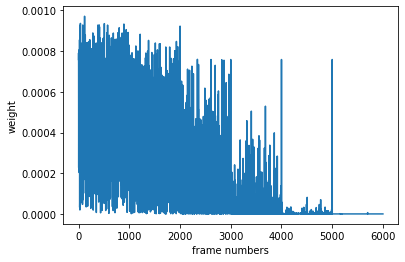

In [44]:
plt.plot(weights)
plt.xlabel("frame numbers")
plt.ylabel("weight")
plt.show()

Clearly the weights decrease for frames corresponding to higher replicas.

Interestingly, the weight of a conformation depends only on the conformation, and not on the number of the frames. As a consequence, the very first frame of each replica, which was equilibrated using the reference potential energy, has a high weight. Probably these frames should be discarded, as system is not equilibrated yet. Anyway, they likely contribute very little to the weights.

The cumulative sum shows clear "kinks" when we pass from one of the replicas to the next one, showing that clearly the average weight depends on the replica index.

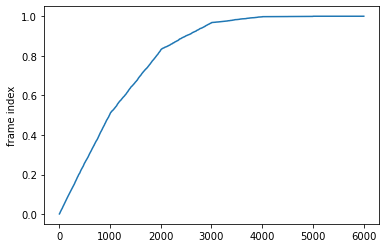

In [45]:
plt.plot(np.cumsum(weights))
plt.ylabel("cumulative sum of weights")
plt.ylabel("frame index")
plt.show()

In [46]:
c=[]
for i in range(len(colvar)):
    c.append(np.array(colvar[i].phi))
colvar_cat=np.hstack(c)
colvar_cat.shape

(6006,)

In [47]:
np.array(colvar[i].phi)
print(
    np.sum(weights*np.logical_and(colvar_cat<2.0,colvar_cat>0))/
    np.sum(weights*np.logical_or(colvar_cat>2.0,colvar_cat<0))
)

0.043619042468797053


In [48]:
weight_of_lambda=[]
for i in range(len(lambdas)): 
    de=(-energies[:,i]+energies[:,0])/kBT
    weight_of_lambda.append(weights*np.exp(de-np.max(de))/np.sum(weights*np.exp(de-np.max(de))))
    
    
pop_wham=[]
for i in range(len(lambdas)):    
    pop_wham.append(
        np.sum(weight_of_lambda[i]*np.logical_and(colvar_cat<2.0,colvar_cat>0))/
        np.sum(weight_of_lambda[i]*np.logical_or(colvar_cat>2.0,colvar_cat<0))
    )

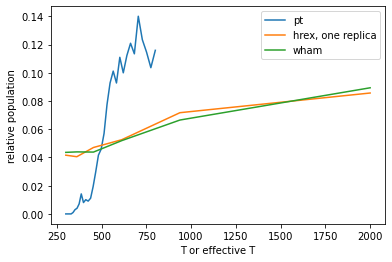

In [49]:
plt.plot(Ts,pop_pt,label="pt")
plt.plot(Ts[0]/lambdas,pop_hrex,label="hrex, one replica")
plt.plot(Ts[0]/lambdas,pop_wham,label="wham")
plt.legend()
plt.xlabel("T or effective T")
plt.ylabel("relative population")
plt.show()


Notice that we can also plot the weights that allow to compute averages at replicas different from the first one.

From the plot below, you can easily see that when you compute weights corresponding to the higher replicas, the frames close to the end of the concatenated trajectory become more important.

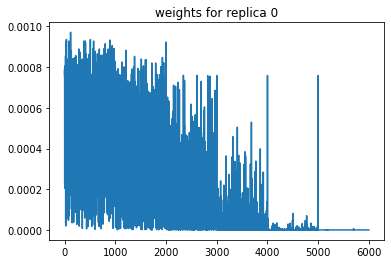

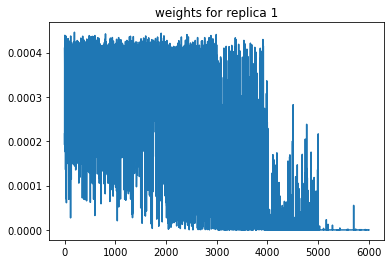

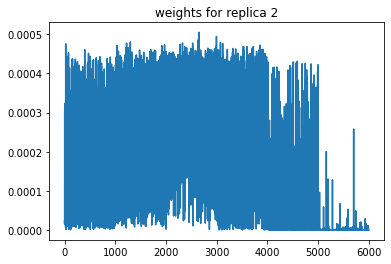

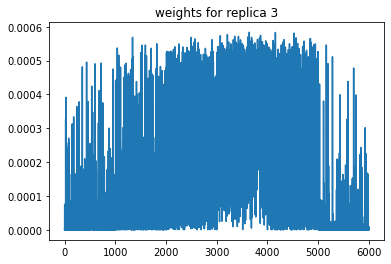

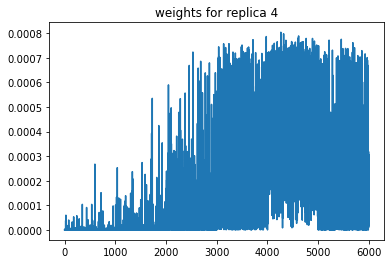

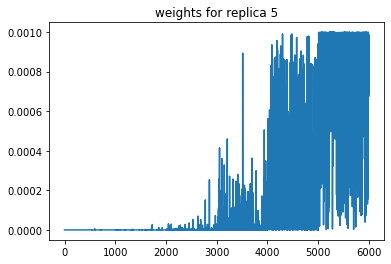

In [50]:
for i in range(len(weight_of_lambda)):
    plt.title("weights for replica {}".format(i))
    plt.plot(weight_of_lambda[i])
    plt.show()

## Exercise 5: Optimize the lambda ladder

We next try to optimize the lambda ladder. To do so, we will run a minimization procedure. In this minimization we should be able to compute averages corresponding to new values of lambda (including values *not* simulated yet!) quickly. To do so, we realize that the energy of a frame is a quadratic function of the sqrt(lambda).

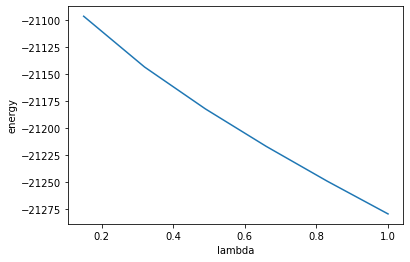

In [51]:
# this is what we see plotting energy as a function of lambda for a random frame
plt.plot(lambdas,energies[100])
plt.xlabel("lambda")
plt.ylabel("energy")
plt.show()

One might think that energy should decrease monotonously with lambda based on the plot above. However, we can just search from frames where this is not true.

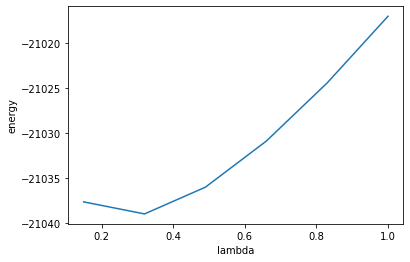

In [52]:
check=[]
for i in range(energies.shape[0]):
    ok=False
    for j in range(energies.shape[1]-1):
        if(energies[i,j]>energies[i,j+1]):
            ok=True
    if ok:
        check.append(i)
check[0]
plt.plot(lambdas,energies[check[0],:])
# this is just one for example
plt.xlabel("lambda")
plt.ylabel("energy")
plt.show()

Then, for each frame, we fit the coefficients of the function that allows us to recompute energies for arbitrary values of lambda

In [53]:
coefficients=[]
for i in range(energies.shape[0]):
    c=np.polyfit(np.sqrt(lambdas),energies[i],2)
    coefficients.append(c)
coefficients=np.array(coefficients)
residual=np.dot(coefficients,
                np.array((lambdas,np.sqrt(lambdas),np.ones(len(lambdas)))))-energies

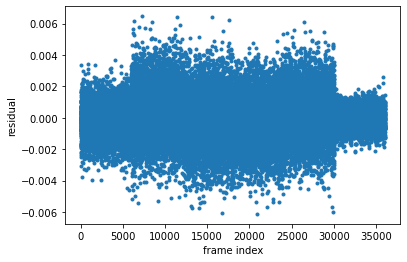

In [54]:
# This is the residual, very small
plt.plot(residual.T.flatten(),".")
plt.xlabel("frame index")
plt.ylabel("residual")
plt.show()

Now we can write a function that predicts the acceptance between two arbitrary values of lambda

In [55]:
def predict_acceptance(l1,l2):
    # energies corresponding to l1 and l2, using the interpolated function
    e1=coefficients[:,0]*l1+coefficients[:,1]*np.sqrt(l1)+coefficients[:,2]
    e2=coefficients[:,0]*l2+coefficients[:,1]*np.sqrt(l2)+coefficients[:,2]
    
    # weights corresponding to l1 and l2
    logW1=w["logW"]-e1/kBT
    logW2=w["logW"]-e2/kBT
    logW1-=np.max(logW1)
    logW2-=np.max(logW2)
    w1=np.exp(logW1)
    w2=np.exp(logW2)
    w1/=np.sum(w1)
    w2/=np.sum(w2)
    
    # then we have to compute the average of the acceptance, which means the average of:
    # np.minimum(w1[j]*w2[i]/(w1[i]*w2[j]),1.0)
    # (compare with Metropolis rule)
    
    # We can do it in two ways. One way is to randomly sample a number (10000, below)
    # of frames from the two ensembles and using them to compute the average acceptance.
    
    #c1=np.random.choice(len(w1),10000,p=w1)
    #c2=np.random.choice(len(w2),10000,p=w2)
    #a=np.minimum(w1[c2]*w2[c1]/(w1[c1]*w2[c2]),1.0)
    #return np.average(a)
    
    # the problem of this approach is that it is random, thus not good to construct a function to be minimized
    
    # alternatively we consider all pairs of frame, with a skip (5) here to just run faster
    w1=w1[::5]
    w2=w2[::5]
    a=[]
    for i in range(len(w1)):
        a.append(np.average(np.minimum(w1[:]*w2[i]/(w1[i]*w2[:]),1.0),weights=w2))
    return np.average(a,weights=w1)   

We can now try to "predict" the acceptance corresponding to the simulated lambdas:

In [56]:
for i in range(len(lambdas)-1):
    print(predict_acceptance(lambdas[i],lambdas[i+1]))

0.5340728519771433
0.4940495074929892
0.39317545103849977
0.2990660445826373
0.11859391076651352


In [57]:
!grep -A 3 "Repl  average probabilities" 3/6reps/replica0/md.log

Repl  average probabilities:
Repl     0    1    2    3    4    5
Repl      .55  .47  .41  .30  .12
Repl  number of exchanges:


Results are very close to the observed averages!

For instance, these would be the acceptance rates predicted for a *geometric* (rather than *linear*) arrangement of lambdas

In [58]:
geometric_lambdas=np.geomspace(1.0,lambdas[-1],len(lambdas))
for i in range(len(lambdas)-1):
    print(predict_acceptance(geometric_lambdas[i],geometric_lambdas[i+1]))

0.2308635220970505
0.2783660937613743
0.3601825408394625
0.405309116856007
0.46225107980567376


The acceptance rates are more even. However, they kind of suffer the opposite problem, namely, acceptance is lower at low replicas. The ladder giving homogeneous rates is somewhere in between linear and geometric.

In [59]:
# lambda is the array with the replicas we used for out simulation (a starting point(
# first and last replicas are fixed (1.0 and lambda_min)
# we thus optimize all elements excluding the first and the last (lambda[1:-1])

lambda_min=lambdas[-1]
 
# this function compute the acceptances given the three intermediate values of
# lambda
def predict_all_acceptances(x):
    x=np.array(x)
    acc=[]
    # lambdas should not be negative
    if np.any(x<=0.0):
        return np.zeros(len(x)+1)
    # nor larger than 1
    if np.any(x>=1.0):
        return np.zeros(len(x)+1)
    # first replica has lambda=1.0
    acc.append(predict_acceptance(1.0,x[0]))
    for i in range(len(x)-1):
        acc.append(predict_acceptance(x[i],x[i+1]))
    # last replica has lambda=lambda_min
    acc.append(predict_acceptance(x[-1],lambda_min))
    return acc
 
# this is function to be minimized
def func(x):
    acc=predict_all_acceptances(x)
    print(np.prod(acc)**(1/len(acc)))
    return -np.prod(acc) # negative, since we minimize the result
 
from scipy.optimize import minimize
res=minimize(func,lambdas[1:-1]) # starting values
optimal_lambdas=np.hstack((1.0,res.x,lambda_min))

print("optimal lambdas: ",optimal_lambdas)
print(predict_all_acceptances(res.x))

0.3259547940141271
0.325954793893094
0.3259547933599866
0.32595479341658784
0.32595479063001087
0.32872898680400764
0.3287289866628208
0.3287289861609084
0.32872898589937016
0.32872898428899244
0.3324338906848852
0.332433890492614
0.3324338900161506
0.332433889264336
0.33243389043460636
0.3335674496997589
0.3335674494601702
0.3335674489523692
0.33356744824582124
0.3335674507617446
0.33492136496655117
0.3349213646673383
0.3349213641049616
0.3349213638673992
0.33492136635635655
0.3370537872278969
0.33705378681141973
0.33705378622693233
0.3370537869108689
0.33705378833631455
0.3387366060583005
0.33873660542528716
0.3387366051464819
0.33873660690403357
0.338736606139612
0.3392440704975935
0.33924406983730954
0.3392440698256017
0.3392440712567459
0.3392440704650873
0.3400495109208426
0.34004951026656627
0.3400495107221155
0.3400495113067745
0.34004951084923557
0.34059499359211687
0.3405949930240917
0.3405949940213559
0.3405949934500063
0.34059499350976274
0.3407499482921569
0.34074994782598

Predicted acceptance are all ~ 0.33.

Below we compare the possible ladders (linear, geometric, and optimal)

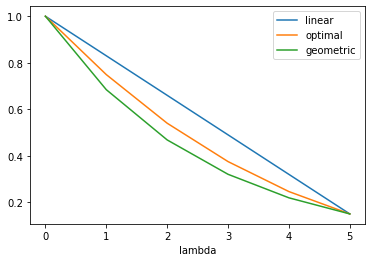

In [60]:
plt.plot(lambdas,label="linear")
plt.plot(optimal_lambdas,label="optimal")
plt.plot(np.geomspace(1.0,lambdas[-1],len(lambdas)),label="geometric")
plt.legend()
plt.xlabel("replica index")
plt.xlabel("lambda")
plt.show()

## Exercise 6: Combine with metadynamics on psi

We next run a metadynamics + solute tempering simulation on psi.

Notice that psi is a **bad** variable for metadynamics on alanine dipeptide.

The setup is basically identical to the one in masterclass 21.5

In [61]:
# hardcoded here if I don't want to rerun previous boxes
optimal_lambdas=np.array([1.,0.7490915,0.54002926,0.37503371,0.24605241,0.15])

In [60]:
# this takes a while
with cd("5/6reps"):
    with open("plumed.dat","w") as f:
        print("""
# vim:ft=plumed
MOLINFO STRUCTURE=../../../ala.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2 
# You can use the same parameters that you used in masterclass 21.4
m: METAD ...
   ARG=psi
   SIGMA=0.3 
   HEIGHT=1.2
   BIASFACTOR=8 
   PACE=500 
   GRID_MIN=-pi 
   GRID_MAX=pi
   FILE=../HILLS_PTMETAD
...
PRINT ARG=phi,psi FILE=../colvar_ptmetad.dat STRIDE=100
        """,file=f) # empty
    for i in range(len(optimal_lambdas)):
        with cd("replica{}".format(i)):
            run_mpi("cp ../../../2a/processed_selected.top processed_selected.top")
            run_mpi("plumed partial_tempering {} < processed_selected.top > topol.top".format(optimal_lambdas[i]))
            run_mpi("gmx_mpi grompp -c ../../../conf.gro -f ../../../grompp.mdp")
    run_mpi("gmx_mpi mdrun -multidir replica? -replex 200 -nsteps 500000 -ntomp 4 -hrex -plumed ../plumed.dat",len(lambdas))

               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     3    Protein residues
There are:   523      Water residues
Analysing Protein...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.035 nm, buffer size 0.035 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 24x24x24, spacing 0.118 0.118 0.118
This run will generate roughly 12 Mb of data


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

Nicely, the acceptance are in agreement with our prediction

In [62]:
!grep -A 3 "Repl  average probabilities" 5/6reps/replica0/md.log

Repl  average probabilities:
Repl     0    1    2    3    4    5
Repl      .34  .34  .32  .35  .33
Repl  number of exchanges:


In [63]:
colvar=[]

for i in range(len(optimal_lambdas)):
    with cd("5/6reps/replica"+str(i)):
        with open("plumed_plot.dat","w") as f:
            print("""
MOLINFO STRUCTURE=../../../ala.pdb 
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
PRINT ARG=phi,psi FILE=COLVAR 
                  """,file=f)
        subprocess.run("plumed driver --ixtc traj_comp.xtc --plumed plumed_plot.dat",shell=True)
            
        colvar.append(plumed.read_as_pandas("COLVAR"))

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed_plot.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary 

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed_plot.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary 

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     0.091335     0.091335     0.091335     0.091335
PLUMED: 1 Prepare dependencies                          1001     0.002040     0.000002     0.000002     0.000013
PLUMED: 2 Sharing data                                  1001     0.010122     0.000010     0.000009     0.000279
PLUMED: 3 Waiting for data                              1001     0.003369     0.000003     0.000003     0.000020
PLUMED: 4 Calculating (forward loop)                    1001     0.011145     0.000011     0.000010     0.000043
PLUMED: 5 Applying (backward loop)                      1001     0.014699     0.000015     0.000014     0.000026
PLUMED: 6 Update                                        1001     0.009292     0.000009     0.000008     0.000056


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed_plot.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary 

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed_plot.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary 

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1591
PLUMED: File suffix: 
PLUMED: FILE: plumed_plot.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../../ala.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 526 and atoms 1 to 1591 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using periodic boundary 

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


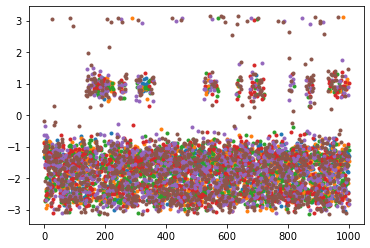

In [64]:
for i in range(len(optimal_lambdas)):
    plt.plot(colvar[i].time,colvar[i].phi,".")

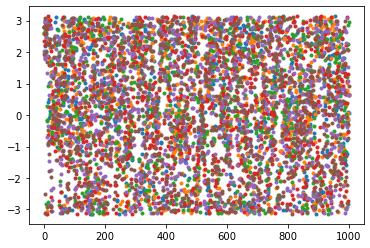

In [65]:
for i in range(len(lambdas)):
    plt.plot(colvar[i].time,colvar[i].psi,".")

Then we concatenate the trajectories to do a WHAM analysis. We also use `mdrun -rerun` to compute energies corresponding to all replicas. In theory, we could do this for 3 replicas only and then interpolate the other values using the trick that we have used in the previous exercise. For simplicitly, we here just rerun with all topologies.

In [65]:
# this takes a while
with cd("5/6reps/"):
    run_mpi("gmx_mpi trjcat -cat -f replica?/traj_comp.xtc -o traj.xtc")
    for i in range(len(optimal_lambdas)):
        run_mpi("gmx_mpi mdrun -rerun traj.xtc -s replica{}/topol.tpr -e energy{}.edr".format(i,i))
        subprocess.run("echo 11 | gmx_mpi energy -f energy{}.edr -xvg no -o energy{}.xvg".format(i,i),shell=True)

               :-) GROMACS - gmx trjcat, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

Note that major changes are planned in future for trjcat, to improve usability and utility.
lasttime 0


Last frame       1000 time 1000.000   
Reading frame       0 time    0.000   
Continue writing frames from replica1/traj_comp.xtc t=0 ps, frame=1001      



lasttime 1000


Last frame       1000 time 1000.000   
Reading frame       0 time    0.000   
Continue writing frames from replica2/traj_comp.xtc t=0 ps, frame=2002      
Reading frame      20 time   20.000   


lasttime 1000


Last frame       1000 time 1000.000   
Reading frame       0 time    0.000   
Continue writing frames from replica3/traj_comp.xtc t=0 ps, frame=3003      
Reading frame     130 time  130.000   


lasttime 1000


Last frame       1000 time 1000.000   
Reading frame       0 time    0.000   
Continue writing frames from replica4/traj_comp.xtc t=0 ps, frame=4004      



lasttime 1000


Last frame       1000 time 1000.000   
Reading frame       0 time    0.000   
Continue writing frames from replica5/traj_comp.xtc t=0 ps, frame=5005      



lasttime 1000


Last frame       1000 time 1000.000   

Last frame written was 6005, time 1000.000000 ps

GROMACS reminds you: "Wild Pointers Couldn't Drag Me Away" (K.A. Feenstra)

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers   


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                  -21069.8        4.4    150.963     5.5878  (kJ/mol)


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                  -21038.1        4.2    146.892    4.43208  (kJ/mol)


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                  -21008.6        4.1    144.031    3.43349  (kJ/mol)


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                  -20982.2          4    142.196    2.60811  (kJ/mol)


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                  -20958.2          4    141.092    1.92307  (kJ/mol)


                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Statistics over 500001 steps [ 0.0000 through 1000.0000 ps ], 1 data sets
All statistics are over 6006 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                  -20936.8        3.9    140.529    1.37059  (kJ/mol)


               :-) GROMACS - gmx energy, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

Additionally, we have to compute the value of the bias potential according to all replicas

In [66]:
# this also takes a while
with cd("5/6reps/"):
    with open("plumed_ptmetad_process.dat","w") as f:
        print("""
# vim:ft=plumed
MOLINFO STRUCTURE=../../ala.pdb 
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2 
m: METAD ...
   ARG=psi
   SIGMA=0.3 
   HEIGHT=0.0
   BIASFACTOR=8 
   PACE=5000000 
   GRID_MIN=-pi 
   GRID_MAX=pi
   FILE=HILLS_PTMETAD
   RESTART=YES
   TEMP=300
...
PRINT ARG=phi,psi,m.bias FILE=colvar_ptmetad_concat.dat
""".format(i,i),file=f)
    run_mpi("plumed driver --multi {} --plumed plumed_ptmetad_process.dat --ixtc traj.xtc".format(len(optimal_lambdas)),len(optimal_lambdas))



PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: ddb59d16b) compiled on May 17 2022 at 19:07:56
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass

Then we read all the calculated energies

In [66]:
energies=[]
bias=[]
with cd("5/6reps"):
    for i in range(len(optimal_lambdas)):
        energies.append(np.loadtxt("energy{}.xvg".format(i),usecols=1))
        bias.append(plumed.read_as_pandas("colvar_ptmetad_concat.{}.dat".format(i))["m.bias"])
energies=np.array(energies).T
bias=np.array(bias).T
energies.shape,bias.shape

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


((6006, 6), (6006, 6))

In [67]:
import wham
kBT=0.00831446261815324*300
w=wham.wham(energies+bias,T=kBT)
# w["logW"] are the Boltzmann factors
# notice that we did not specify yet to which ensemble we are reweighting
# this can be done with the following line:
logW=w["logW"]-energies[:,0]/kBT
# logW are the logaritm weights to obtain properties corresponding to replica 0
logW-=np.max(logW) # avoid numerical errors in exp
weights=np.exp(logW)
weights/=np.sum(weights) # normalize weights
# these weights can be used to compute weighted averages

In [68]:
with cd("5/6reps"):
    colvar_cat=plumed.read_as_pandas("colvar_ptmetad_concat.0.dat")["phi"] # any replica would be fine

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/net/sbp/sbpstore1/bussi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


In [69]:
print(
    np.sum(weights*np.logical_and(colvar_cat<2.0,colvar_cat>0))/
    np.sum(weights*np.logical_or(colvar_cat>2.0,colvar_cat<0))
)

0.02000781840905731


In [70]:
weight_of_lambda=[]
for i in range(len(optimal_lambdas)): 
    de=(-energies[:,i]+energies[:,0])/kBT
    weight_of_lambda.append(weights*np.exp(de-np.max(de))/np.sum(weights*np.exp(de-np.max(de))))
    
    
pop_metad=[]
for i in range(len(optimal_lambdas)):    
    pop_metad.append(
        np.sum(weight_of_lambda[i]*np.logical_and(colvar_cat<2.0,colvar_cat>0))/
        np.sum(weight_of_lambda[i]*np.logical_or(colvar_cat>2.0,colvar_cat<0))
    )


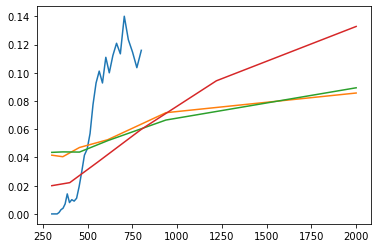

In [71]:
plt.plot(Ts,pop_pt,label="pt")
plt.plot(Ts[0]/lambdas,pop_hrex,label="hrex")
plt.plot(Ts[0]/lambdas,pop_wham,label="wham")
plt.plot(Ts[0]/optimal_lambdas,pop_metad,label="metad+wham")
plt.show()


Weird, there is some difference. I now test the result using individual replicas

In [77]:
pop_metad_single=[]
for i in range(6):
    colvar1=colvar_cat[1001*i:1001*(i+1)]
    weights1=np.exp((bias[1001*i:1001*(i+1),i]-np.max(bias[1001*i:1001*(i+1),i]))/kBT)
    weights1=np.exp(weights1)
    weights1/=np.sum(weights1)
    pop_metad_single.append(
        np.sum(weights1*np.logical_and(colvar1<2.0,colvar1>0))/
        np.sum(weights1*np.logical_or(colvar1>2.0,colvar1<0))
    )

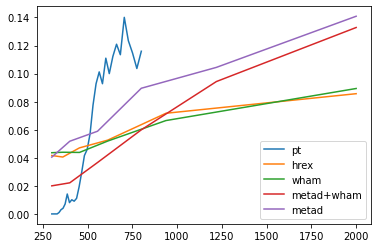

In [78]:
plt.plot(Ts,pop_pt,label="pt")
plt.plot(Ts[0]/lambdas,pop_hrex,label="hrex")
plt.plot(Ts[0]/lambdas,pop_wham,label="wham")
plt.plot(Ts[0]/optimal_lambdas,pop_metad,label="metad+wham")
plt.plot(Ts[0]/optimal_lambdas,pop_metad_single,label="metad")
plt.legend()
plt.show()

Likely there is some convergence problem at small lambda!

Compare with results from a longer simulation